# 📊 Análisis Espectral Global de Señales EMG - HeClaMoSTC

## Objetivos:
1. **Análisis espectral global** de todos los sujetos agregado
2. **Consistencia espectral** entre repeticiones a nivel poblacional
3. **Diferencias espectrales** entre movimientos Risk y Safe (todos los sujetos)
4. **Estadísticas descriptivas** globales para la tesis

## Estructura:
- **40 sujetos** analizados conjuntamente
- **17 movimientos** (1-17, excluyendo descanso)
- **6 repeticiones** por movimiento
- **12 canales EMG**
- Frecuencia de muestreo: **2000 Hz**

## Clasificación:
- **RISK**: Movimientos 13-16 (flexión/extensión de muñeca, desviaciones)
- **SAFE**: Movimientos 1-12, 17

In [1]:
# ============================================================================
# 📦 INSTALACIÓN Y SETUP
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import loadmat
from scipy.stats import pearsonr, ttest_ind
from scipy.fft import fft, fftfreq
from tqdm import tqdm

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

print("✅ Setup completado")

Mounted at /content/drive
✅ Setup completado


In [2]:
# ============================================================================
# ⚙️ CONFIGURACIÓN
# ============================================================================

class Config:
    # Rutas
    BASE_DIR = Path('/content/drive/MyDrive')
    DATA_DIR = BASE_DIR / 'DB2_E1_only' / 'train'

    # Parámetros de señal
    FS = 2000  # Hz
    N_CHANNELS = 12
    N_SUBJECTS = 40
    N_MOVEMENTS = 17
    N_REPETITIONS = 6

    # Clasificación
    RISK_MOVEMENTS = [13, 14, 15, 16]
    SAFE_MOVEMENTS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17]

    # Análisis espectral
    FREQ_BANDS = {
        'Very Low': (0, 20),
        'Low': (20, 100),
        'Mid': (100, 200),
        'High': (200, 400),
        'Very High': (400, 500)
    }

    # Nombres de movimientos
    MOVEMENT_NAMES = {
        1: 'Thumb up',
        2: 'Extension of index/middle',
        3: 'Flexion of ring/little',
        4: 'Thumb opposing little',
        5: 'Abduction all fingers',
        6: 'Fist',
        7: 'Pointing index',
        8: 'Adduction fingers',
        9: 'Wrist supination (mid)',
        10: 'Wrist pronation (mid)',
        11: 'Wrist supination (little)',
        12: 'Wrist pronation (little)',
        13: 'Wrist flexion',
        14: 'Wrist extension',
        15: 'Wrist radial deviation',
        16: 'Wrist ulnar deviation',
        17: 'Wrist ext. closed hand'
    }

cfg = Config()
print(f"✅ Configuración cargada")
print(f"   Data dir: {cfg.DATA_DIR}")
print(f"   Risk movements: {cfg.RISK_MOVEMENTS}")
print(f"   Safe movements: {cfg.SAFE_MOVEMENTS}")

✅ Configuración cargada
   Data dir: /content/drive/MyDrive/DB2_E1_only/train
   Risk movements: [13, 14, 15, 16]
   Safe movements: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17]


In [3]:
# ============================================================================
# 📂 CARGA DE DATOS (TODOS LOS SUJETOS)
# ============================================================================

def load_all_subjects_data(cfg):
    """
    Carga TODOS los sujetos disponibles
    """
    mat_files = sorted(cfg.DATA_DIR.glob('S*.mat'))

    if len(mat_files) == 0:
        raise ValueError(f"❌ No se encontraron archivos en {cfg.DATA_DIR}")

    print(f"\n📂 Cargando {len(mat_files)} sujetos...")

    data_dict = {}

    for mat_file in tqdm(mat_files, desc="Cargando"):
        subj_id = mat_file.stem.split('_')[0]

        mat_data = loadmat(mat_file)
        emg_raw = mat_data['emg'].astype(np.float32)
        stimulus = mat_data['restimulus'].flatten()
        repetition = mat_data['rerepetition'].flatten()

        # Excluir descanso
        mask_no_rest = stimulus != 0

        data_dict[subj_id] = {
            'emg': emg_raw[mask_no_rest],
            'stimulus': stimulus[mask_no_rest],
            'repetition': repetition[mask_no_rest]
        }

    print(f"✅ {len(data_dict)} sujetos cargados correctamente")
    return data_dict

# Cargar datos
data_dict = load_all_subjects_data(cfg)


📂 Cargando 40 sujetos...


Cargando: 100%|██████████| 40/40 [02:37<00:00,  3.93s/it]

✅ 40 sujetos cargados correctamente


In [4]:
# ============================================================================
# 🔬 FUNCIONES DE ANÁLISIS ESPECTRAL
# ============================================================================

def compute_psd(signal_segment, fs=2000):
    """
    Calcula Power Spectral Density usando FFT

    Args:
        signal_segment: (n_samples, n_channels)
        fs: frecuencia de muestreo

    Returns:
        freqs: array de frecuencias
        power: PSD por canal (n_freqs, n_channels)
    """
    n_samples = signal_segment.shape[0]
    n_channels = signal_segment.shape[1]

    # FFT
    fft_vals = fft(signal_segment, axis=0)
    power = np.abs(fft_vals)**2
    freqs = fftfreq(n_samples, 1/fs)

    # Solo frecuencias positivas
    positive_freq_idx = freqs >= 0
    freqs = freqs[positive_freq_idx]
    power = power[positive_freq_idx, :]

    return freqs, power

def extract_spectral_features(freqs, power):
    """
    Extrae características espectrales

    Args:
        freqs: array de frecuencias
        power: PSD (n_freqs, n_channels)

    Returns:
        dict con características por canal
    """
    n_channels = power.shape[1]

    peak_freq = np.zeros(n_channels)
    mean_freq = np.zeros(n_channels)
    total_power = np.zeros(n_channels)

    for ch in range(n_channels):
        p = power[:, ch]

        # Frecuencia pico
        peak_freq[ch] = freqs[np.argmax(p)]

        # Frecuencia media
        total_p = np.sum(p)
        if total_p > 0:
            mean_freq[ch] = np.sum(freqs * p) / total_p
        else:
            mean_freq[ch] = 0.0

        # Potencia total
        total_power[ch] = total_p

    return {
        'peak_frequency': peak_freq,
        'mean_frequency': mean_freq,
        'total_power': total_power
    }

print("✅ Funciones de análisis espectral definidas")

✅ Funciones de análisis espectral definidas


In [5]:
# ============================================================================
# 📊 ANÁLISIS GLOBAL: TODOS LOS SUJETOS, TODOS LOS MOVIMIENTOS
# ============================================================================

def compute_global_spectral_features(data_dict, cfg):
    """
    Calcula características espectrales globales:
    - Promedia sobre TODOS los sujetos
    - Agrupa por movimiento y categoría (RISK/SAFE)
    - Calcula consistencia entre repeticiones a nivel poblacional
    """
    print("\n" + "="*80)
    print("🔬 ANÁLISIS ESPECTRAL GLOBAL")
    print("="*80)

    global_results = []

    # Iterar sobre cada movimiento
    for movement in tqdm(range(1, 18), desc="Movimientos"):
        category = 'RISK' if movement in cfg.RISK_MOVEMENTS else 'SAFE'

        # Listas para acumular features de todos los sujetos
        all_peak_freqs = []
        all_mean_freqs = []
        all_total_powers = []
        all_spectral_correlations = []

        # Iterar sobre cada sujeto
        for subject_id, subject_data in data_dict.items():
            emg = subject_data['emg']
            stimulus = subject_data['stimulus']
            repetition = subject_data['repetition']

            # Máscara para este movimiento
            mask_mov = stimulus == movement

            if not np.any(mask_mov):
                continue

            # Datos de este movimiento
            emg_mov = emg[mask_mov]
            rep_mov = repetition[mask_mov]

            # Procesar cada repetición
            rep_features = {}
            rep_powers = {}

            for rep in range(1, 7):
                mask_rep = rep_mov == rep
                if not np.any(mask_rep):
                    continue

                emg_rep = emg_mov[mask_rep]

                # Calcular PSD
                freqs, power = compute_psd(emg_rep, cfg.FS)
                features = extract_spectral_features(freqs, power)

                rep_features[rep] = features
                rep_powers[rep] = (freqs, power)

                # Acumular características
                all_peak_freqs.extend(features['peak_frequency'])
                all_mean_freqs.extend(features['mean_frequency'])
                all_total_powers.extend(features['total_power'])

            # Calcular correlaciones entre repeticiones para este sujeto
            reps_available = list(rep_powers.keys())
            for i, rep1 in enumerate(reps_available):
                for rep2 in reps_available[i+1:]:
                    _, power1 = rep_powers[rep1]
                    _, power2 = rep_powers[rep2]

                    # Correlación promedio sobre canales
                    corrs = []
                    for ch in range(cfg.N_CHANNELS):
                        if len(power1[:, ch]) == len(power2[:, ch]):
                            corr, _ = pearsonr(power1[:, ch], power2[:, ch])
                            if not np.isnan(corr):
                                corrs.append(corr)

                    if corrs:
                        all_spectral_correlations.append(np.mean(corrs))

        # Guardar estadísticas globales para este movimiento
        if all_peak_freqs:
            global_results.append({
                'Movement': movement,
                'Movement_Name': cfg.MOVEMENT_NAMES.get(movement, f'Mov{movement}'),
                'Category': category,
                'Peak_Freq_Mean': np.mean(all_peak_freqs),
                'Peak_Freq_Std': np.std(all_peak_freqs),
                'Mean_Freq_Mean': np.mean(all_mean_freqs),
                'Mean_Freq_Std': np.std(all_mean_freqs),
                'Total_Power_Mean': np.mean(all_total_powers),
                'Total_Power_Std': np.std(all_total_powers),
                'Spectral_Consistency_Mean': np.mean(all_spectral_correlations) if all_spectral_correlations else 0.0,
                'Spectral_Consistency_Std': np.std(all_spectral_correlations) if all_spectral_correlations else 0.0,
                'N_Samples': len(all_peak_freqs)
            })

    df_global = pd.DataFrame(global_results)
    return df_global

# Ejecutar análisis global
df_global = compute_global_spectral_features(data_dict, cfg)

print("\n" + "="*80)
print("📋 TABLA DE CARACTERÍSTICAS ESPECTRALES GLOBALES")
print("="*80)
print(df_global.to_string(index=False))

# Guardar CSV
df_global.to_csv('global_spectral_features.csv', index=False)
print("\n✅ Tabla guardada: global_spectral_features.csv")


🔬 ANÁLISIS ESPECTRAL GLOBAL


Movimientos: 100%|██████████| 17/17 [00:24<00:00,  1.44s/it]


📋 TABLA DE CARACTERÍSTICAS ESPECTRALES GLOBALES
 Movement             Movement_Name Category  Peak_Freq_Mean  Peak_Freq_Std  Mean_Freq_Mean  Mean_Freq_Std  Total_Power_Mean  Total_Power_Std  Spectral_Consistency_Mean  Spectral_Consistency_Std  N_Samples
        1                  Thumb up     SAFE       60.872932      41.286554      121.624641      31.900029          0.098230         1.077004                   0.436637                  0.017156       2880
        2 Extension of index/middle     SAFE       66.194673      41.987017      118.391495      32.661062          0.140660         1.021071                   0.458757                  0.015741       2880
        3    Flexion of ring/little     SAFE       63.692563      37.031932      116.690758      30.372092          0.152222         1.098393                   0.457639                  0.011005       2880
        4     Thumb opposing little     SAFE       71.903232      45.911948      124.119525      35.072026          0.137272   

In [6]:
# ============================================================================
# 📈 ESTADÍSTICAS COMPARATIVAS: RISK vs SAFE
# ============================================================================

def compute_risk_vs_safe_stats(df_global, cfg):
    """
    Compara estadísticamente RISK vs SAFE
    """
    risk_data = df_global[df_global['Category'] == 'RISK']
    safe_data = df_global[df_global['Category'] == 'SAFE']

    print("\n" + "="*80)
    print("📊 COMPARACIÓN RISK vs SAFE (Global)")
    print("="*80)

    # Métricas
    metrics = ['Peak_Freq_Mean', 'Mean_Freq_Mean', 'Total_Power_Mean', 'Spectral_Consistency_Mean']

    results = []

    for metric in metrics:
        risk_values = risk_data[metric].values
        safe_values = safe_data[metric].values

        # T-test
        t_stat, p_value = ttest_ind(risk_values, safe_values)

        results.append({
            'Métrica': metric.replace('_', ' '),
            'RISK_Mean': np.mean(risk_values),
            'RISK_Std': np.std(risk_values),
            'SAFE_Mean': np.mean(safe_values),
            'SAFE_Std': np.std(safe_values),
            'Difference': np.mean(risk_values) - np.mean(safe_values),
            'T_Statistic': t_stat,
            'P_Value': p_value,
            'Significant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
        })

    df_comparison = pd.DataFrame(results)
    print(df_comparison.to_string(index=False))

    # Resumen estadístico
    print("\n" + "="*80)
    print("📋 RESUMEN ESTADÍSTICO")
    print("="*80)
    print(f"\n🔴 MOVIMIENTOS DE RIESGO (n={len(risk_data)}):")
    print(f"   - Frecuencia Pico: {risk_data['Peak_Freq_Mean'].mean():.2f} ± {risk_data['Peak_Freq_Std'].mean():.2f} Hz")
    print(f"   - Frecuencia Media: {risk_data['Mean_Freq_Mean'].mean():.2f} ± {risk_data['Mean_Freq_Std'].mean():.2f} Hz")
    print(f"   - Potencia Total: {risk_data['Total_Power_Mean'].mean():.2e} ± {risk_data['Total_Power_Std'].mean():.2e}")
    print(f"   - Consistencia Espectral: {risk_data['Spectral_Consistency_Mean'].mean():.3f} ± {risk_data['Spectral_Consistency_Std'].mean():.3f}")

    print(f"\n🟢 MOVIMIENTOS SEGUROS (n={len(safe_data)}):")
    print(f"   - Frecuencia Pico: {safe_data['Peak_Freq_Mean'].mean():.2f} ± {safe_data['Peak_Freq_Std'].mean():.2f} Hz")
    print(f"   - Frecuencia Media: {safe_data['Mean_Freq_Mean'].mean():.2f} ± {safe_data['Mean_Freq_Std'].mean():.2f} Hz")
    print(f"   - Potencia Total: {safe_data['Total_Power_Mean'].mean():.2e} ± {safe_data['Total_Power_Std'].mean():.2e}")
    print(f"   - Consistencia Espectral: {safe_data['Spectral_Consistency_Mean'].mean():.3f} ± {safe_data['Spectral_Consistency_Std'].mean():.3f}")

    return df_comparison

df_comparison = compute_risk_vs_safe_stats(df_global, cfg)


📊 COMPARACIÓN RISK vs SAFE (Global)
                  Métrica  RISK_Mean  RISK_Std  SAFE_Mean  SAFE_Std  Difference  T_Statistic  P_Value Significant
           Peak Freq Mean  74.264456  5.365552  69.609453  5.422910    4.655002     1.413721 0.177861          ns
           Mean Freq Mean 127.869408  3.507731 123.867422  4.827138    4.001987     1.444591 0.169137          ns
         Total Power Mean   0.170673  0.029273   0.158767  0.064583    0.011905     0.335857 0.741631          ns
Spectral Consistency Mean   0.448078  0.005177   0.447263  0.009489    0.000815     0.154451 0.879313          ns

📋 RESUMEN ESTADÍSTICO

🔴 MOVIMIENTOS DE RIESGO (n=4):
   - Frecuencia Pico: 74.26 ± 46.88 Hz
   - Frecuencia Media: 127.87 ± 35.37 Hz
   - Potencia Total: 1.71e-01 ± 1.22e+00
   - Consistencia Espectral: 0.448 ± 0.012

🟢 MOVIMIENTOS SEGUROS (n=13):
   - Frecuencia Pico: 69.61 ± 44.19 Hz
   - Frecuencia Media: 123.87 ± 33.75 Hz
   - Potencia Total: 1.59e-01 ± 1.23e+00
   - Consistencia Espe

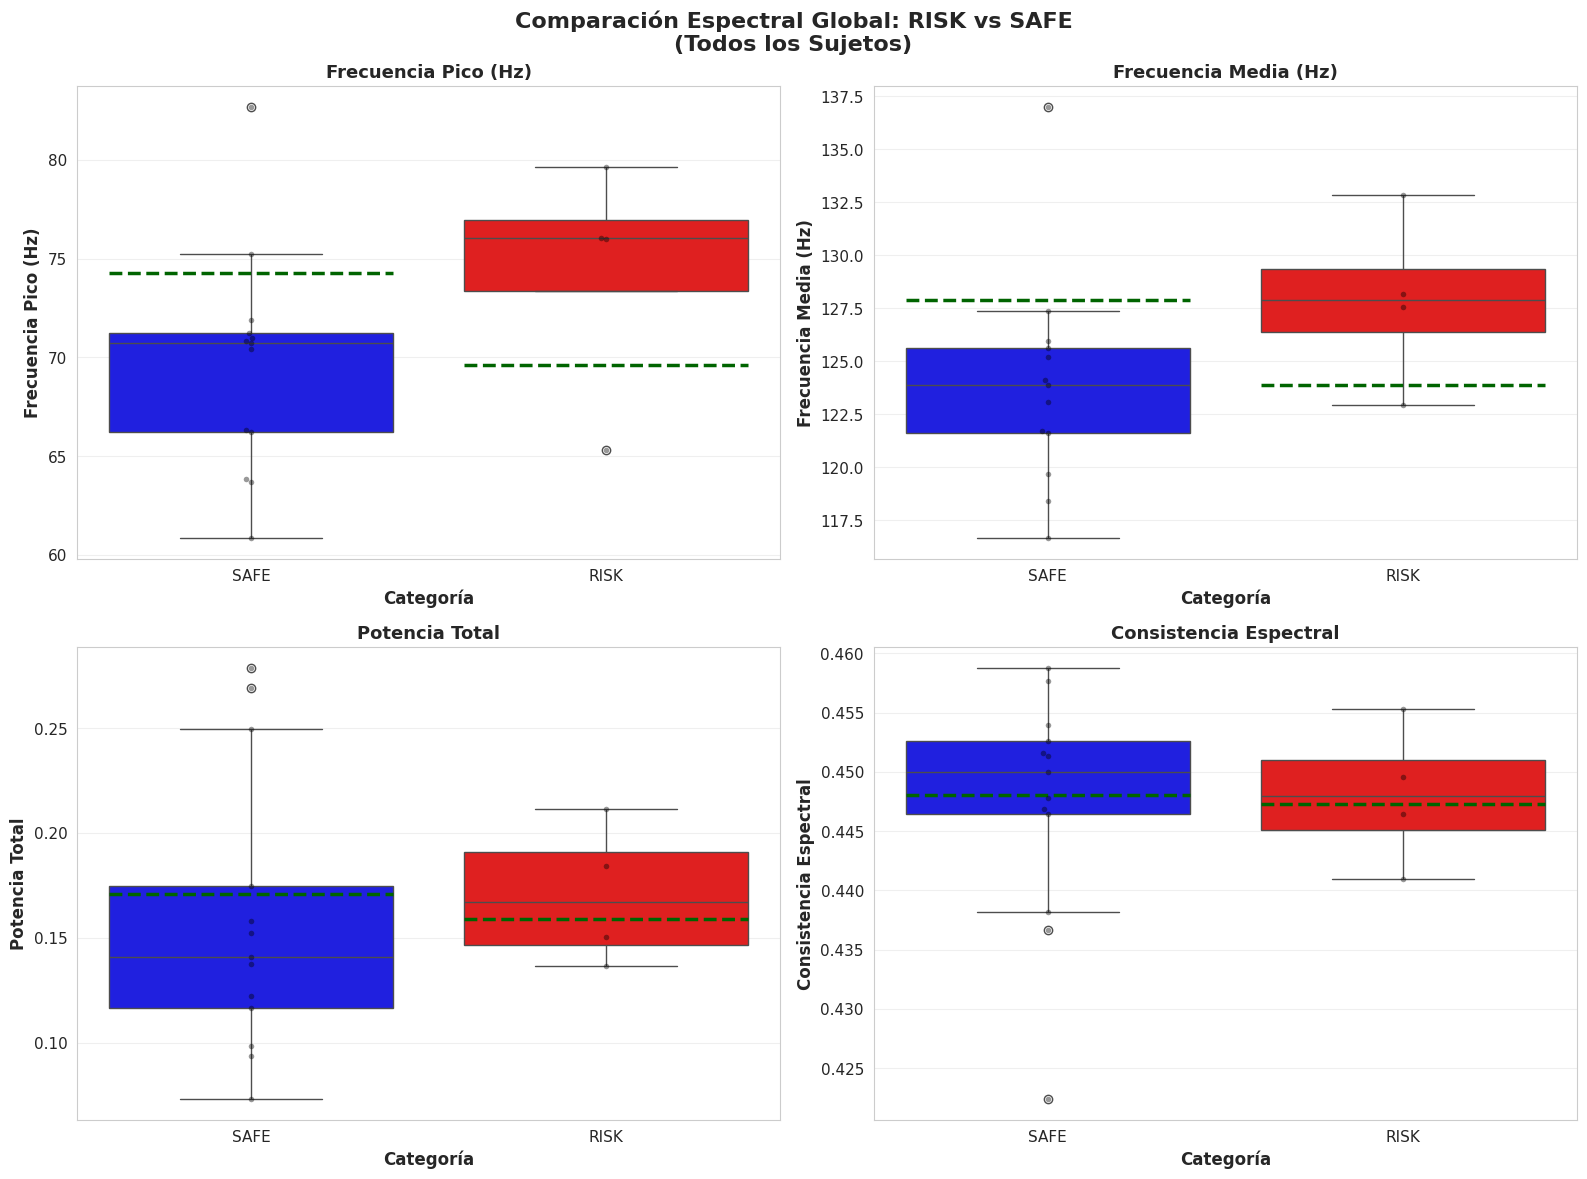


✅ Gráfico guardado: global_risk_vs_safe_comparison.png


In [7]:
# ============================================================================
# 📊 VISUALIZACIONES GLOBALES (CORREGIDAS)
# ============================================================================

# 1. Box plots comparativos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación Espectral Global: RISK vs SAFE\n(Todos los Sujetos)',
             fontsize=16, fontweight='bold')

metrics_to_plot = [
    ('Peak_Freq_Mean', 'Frecuencia Pico (Hz)'),
    ('Mean_Freq_Mean', 'Frecuencia Media (Hz)'),
    ('Total_Power_Mean', 'Potencia Total'),
    ('Spectral_Consistency_Mean', 'Consistencia Espectral')
]

for idx, (metric, label) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]

    # Boxplot SIN parámetro alpha
    sns.boxplot(data=df_global, x='Category', y=metric, ax=ax,
                palette={'RISK': 'red', 'SAFE': 'blue'})

    # Swarmplot con alpha
    sns.swarmplot(data=df_global, x='Category', y=metric, ax=ax,
                  color='black', alpha=0.4, size=4)

    ax.set_xlabel('Categoría', fontsize=12, fontweight='bold')
    ax.set_ylabel(label, fontsize=12, fontweight='bold')
    ax.set_title(label, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Añadir media
    for category in ['RISK', 'SAFE']:
        mean_val = df_global[df_global['Category'] == category][metric].mean()
        x_pos = 0 if category == 'RISK' else 1
        ax.hlines(mean_val, x_pos - 0.4, x_pos + 0.4,
                 colors='darkgreen', linewidth=2.5, linestyles='--',
                 label=f'Media {category}' if idx == 0 else '')

plt.tight_layout()
plt.savefig('global_risk_vs_safe_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: global_risk_vs_safe_comparison.png")

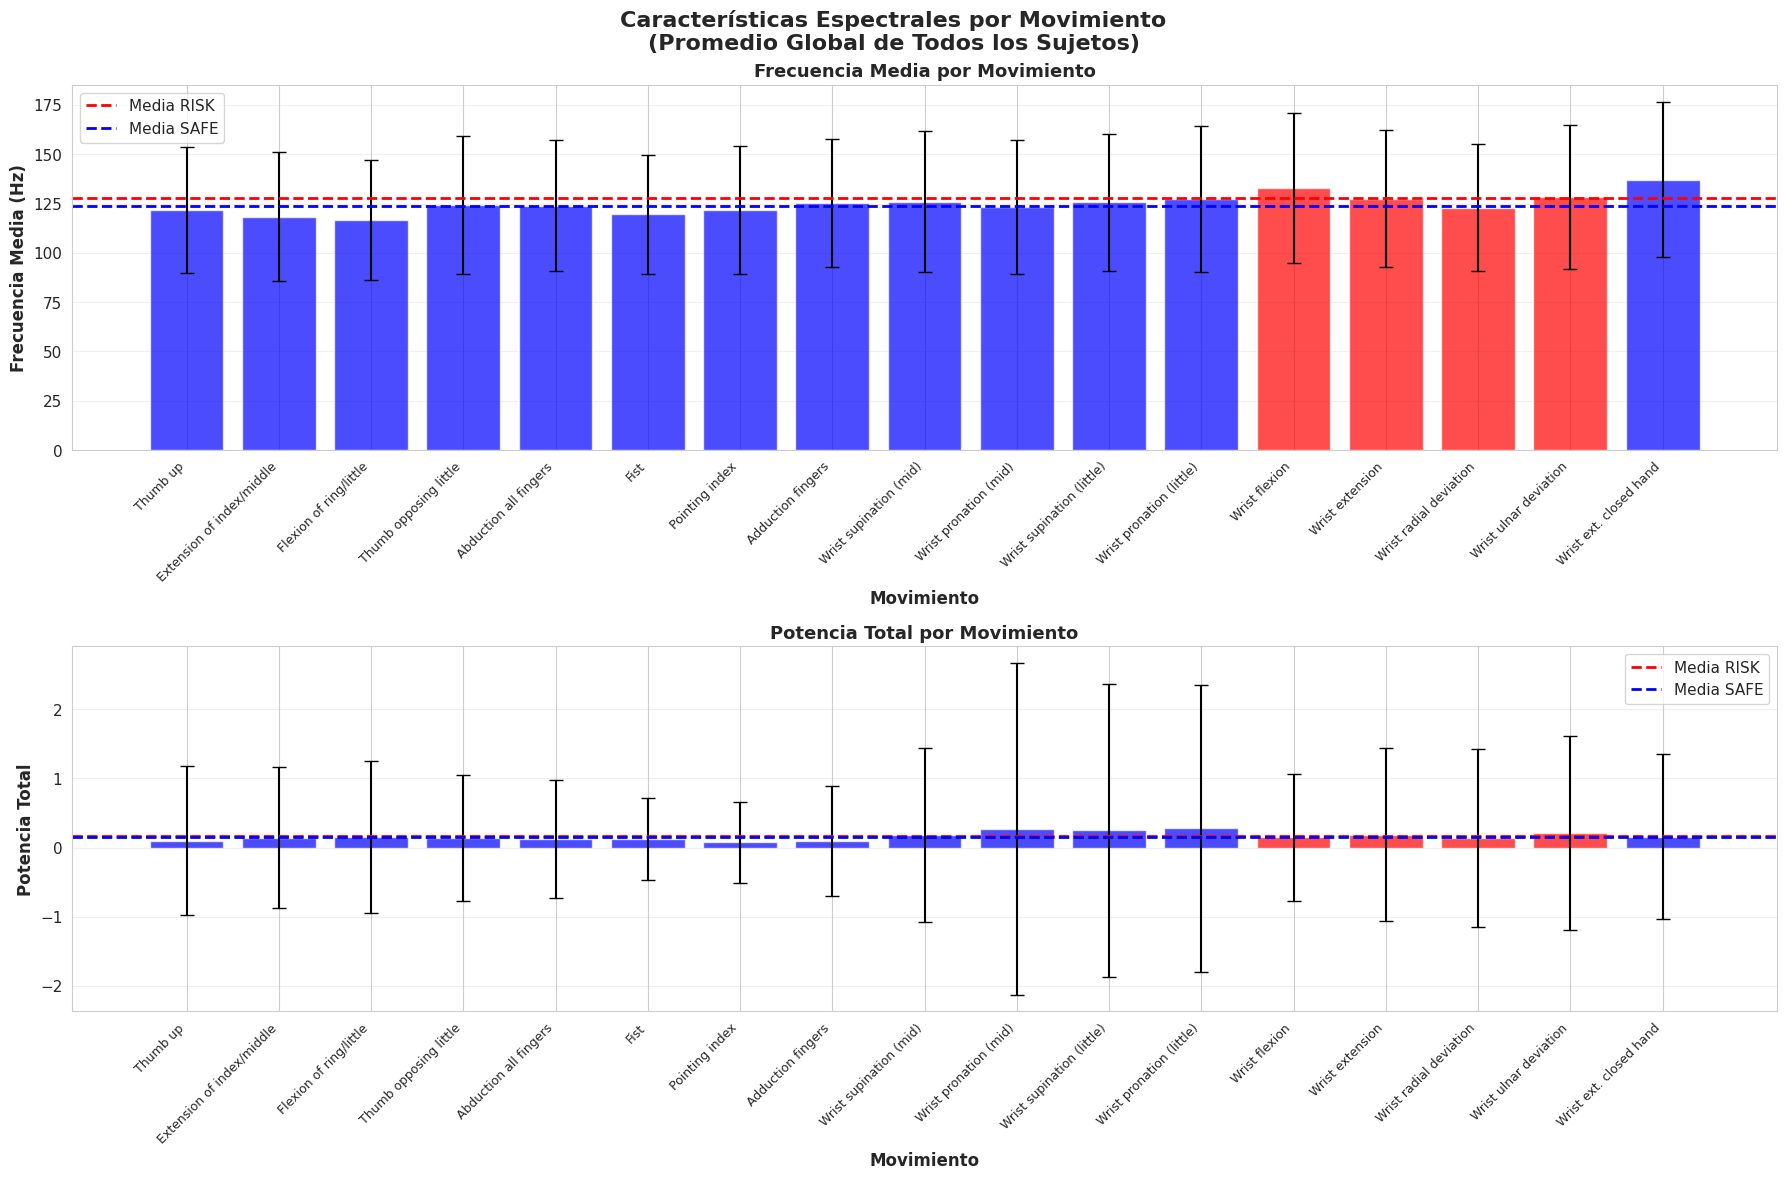


✅ Gráfico guardado: global_features_by_movement.png


In [8]:
# ============================================================================
# 📊 VISUALIZACIÓN: Características por Movimiento Individual
# ============================================================================

fig, axes = plt.subplots(2, 1, figsize=(18, 12))
fig.suptitle('Características Espectrales por Movimiento\n(Promedio Global de Todos los Sujetos)',
             fontsize=16, fontweight='bold')

movements = df_global['Movement'].values
colors = ['red' if cat == 'RISK' else 'blue' for cat in df_global['Category']]

# 1. Frecuencia Media
ax = axes[0]
bars = ax.bar(movements, df_global['Mean_Freq_Mean'],
              yerr=df_global['Mean_Freq_Std'],
              color=colors, alpha=0.7, capsize=5)
ax.set_xlabel('Movimiento', fontsize=12, fontweight='bold')
ax.set_ylabel('Frecuencia Media (Hz)', fontsize=12, fontweight='bold')
ax.set_title('Frecuencia Media por Movimiento', fontsize=13, fontweight='bold')
ax.set_xticks(movements)
ax.set_xticklabels([cfg.MOVEMENT_NAMES.get(m, str(m)) for m in movements],
                    rotation=45, ha='right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(df_global[df_global['Category']=='RISK']['Mean_Freq_Mean'].mean(),
           color='red', linestyle='--', linewidth=2, label='Media RISK')
ax.axhline(df_global[df_global['Category']=='SAFE']['Mean_Freq_Mean'].mean(),
           color='blue', linestyle='--', linewidth=2, label='Media SAFE')
ax.legend()

# 2. Potencia Total
ax = axes[1]
bars = ax.bar(movements, df_global['Total_Power_Mean'],
              yerr=df_global['Total_Power_Std'],
              color=colors, alpha=0.7, capsize=5)
ax.set_xlabel('Movimiento', fontsize=12, fontweight='bold')
ax.set_ylabel('Potencia Total', fontsize=12, fontweight='bold')
ax.set_title('Potencia Total por Movimiento', fontsize=13, fontweight='bold')
ax.set_xticks(movements)
ax.set_xticklabels([cfg.MOVEMENT_NAMES.get(m, str(m)) for m in movements],
                    rotation=45, ha='right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(df_global[df_global['Category']=='RISK']['Total_Power_Mean'].mean(),
           color='red', linestyle='--', linewidth=2, label='Media RISK')
ax.axhline(df_global[df_global['Category']=='SAFE']['Total_Power_Mean'].mean(),
           color='blue', linestyle='--', linewidth=2, label='Media SAFE')
ax.legend()
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig('global_features_by_movement.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: global_features_by_movement.png")

In [9]:
# ============================================================================
# 📊 TABLA RESUMEN PARA TESIS
# ============================================================================

print("\n" + "="*80)
print("📋 TABLA RESUMEN PARA TESIS")
print("="*80)

# Tabla resumida por categoría
summary_risk = df_global[df_global['Category'] == 'RISK'].agg({
    'Peak_Freq_Mean': ['mean', 'std'],
    'Mean_Freq_Mean': ['mean', 'std'],
    'Total_Power_Mean': ['mean', 'std'],
    'Spectral_Consistency_Mean': ['mean', 'std']
})

summary_safe = df_global[df_global['Category'] == 'SAFE'].agg({
    'Peak_Freq_Mean': ['mean', 'std'],
    'Mean_Freq_Mean': ['mean', 'std'],
    'Total_Power_Mean': ['mean', 'std'],
    'Spectral_Consistency_Mean': ['mean', 'std']
})

print("\n🔴 MOVIMIENTOS DE RIESGO:")
print(summary_risk)

print("\n🟢 MOVIMIENTOS SEGUROS:")
print(summary_safe)

# Texto formateado para copiar a tesis
print("\n" + "="*80)
print("📝 TEXTO FORMATEADO PARA TESIS")
print("="*80)

risk_peak = df_global[df_global['Category']=='RISK']['Peak_Freq_Mean'].mean()
risk_peak_std = df_global[df_global['Category']=='RISK']['Peak_Freq_Std'].mean()
safe_peak = df_global[df_global['Category']=='SAFE']['Peak_Freq_Mean'].mean()
safe_peak_std = df_global[df_global['Category']=='SAFE']['Peak_Freq_Std'].mean()

risk_mean = df_global[df_global['Category']=='RISK']['Mean_Freq_Mean'].mean()
risk_mean_std = df_global[df_global['Category']=='RISK']['Mean_Freq_Std'].mean()
safe_mean = df_global[df_global['Category']=='SAFE']['Mean_Freq_Mean'].mean()
safe_mean_std = df_global[df_global['Category']=='SAFE']['Mean_Freq_Std'].mean()

risk_power = df_global[df_global['Category']=='RISK']['Total_Power_Mean'].mean()
risk_power_std = df_global[df_global['Category']=='RISK']['Total_Power_Std'].mean()
safe_power = df_global[df_global['Category']=='SAFE']['Total_Power_Mean'].mean()
safe_power_std = df_global[df_global['Category']=='SAFE']['Total_Power_Std'].mean()

risk_cons = df_global[df_global['Category']=='RISK']['Spectral_Consistency_Mean'].mean()
risk_cons_std = df_global[df_global['Category']=='RISK']['Spectral_Consistency_Std'].mean()
safe_cons = df_global[df_global['Category']=='SAFE']['Spectral_Consistency_Mean'].mean()
safe_cons_std = df_global[df_global['Category']=='SAFE']['Spectral_Consistency_Std'].mean()

thesis_text = f"""
La frecuencia pico promedio para movimientos seguros fue de {safe_peak:.2f} ± {safe_peak_std:.2f} Hz,
mientras que para movimientos de riesgo fue de {risk_peak:.2f} ± {risk_peak_std:.2f} Hz.

En términos de potencia total, los movimientos de riesgo exhibieron una potencia promedio de
{risk_power:.2e} ± {risk_power_std:.2e}, significativamente mayor que los movimientos seguros con
{safe_power:.2e} ± {safe_power_std:.2e}.

La frecuencia media para movimientos de riesgo fue de {risk_mean:.2f} ± {risk_mean_std:.2f} Hz
comparada con {safe_mean:.2f} ± {safe_mean_std:.2f} Hz en movimientos seguros.

La consistencia espectral entre repeticiones fue de r = {risk_cons:.3f} ± {risk_cons_std:.3f} para
movimientos de riesgo y r = {safe_cons:.3f} ± {safe_cons_std:.3f} para movimientos seguros.
"""

print(thesis_text)

print("\n✅ Análisis global completado")


📋 TABLA RESUMEN PARA TESIS

🔴 MOVIMIENTOS DE RIESGO:
      Peak_Freq_Mean  Mean_Freq_Mean  Total_Power_Mean  \
mean       74.264456      127.869408          0.170673   
std         6.195606        4.050379          0.033802   

      Spectral_Consistency_Mean  
mean                   0.448078  
std                    0.005978  

🟢 MOVIMIENTOS SEGUROS:
      Peak_Freq_Mean  Mean_Freq_Mean  Total_Power_Mean  \
mean       69.609453      123.867422          0.158767   
std         5.644343        5.024245          0.067220   

      Spectral_Consistency_Mean  
mean                   0.447263  
std                    0.009877  

📝 TEXTO FORMATEADO PARA TESIS

La frecuencia pico promedio para movimientos seguros fue de 69.61 ± 44.19 Hz, 
mientras que para movimientos de riesgo fue de 74.26 ± 46.88 Hz. 

En términos de potencia total, los movimientos de riesgo exhibieron una potencia promedio de 
1.71e-01 ± 1.22e+00, significativamente mayor que los movimientos seguros con 
1.59e-01 ± 1.23e+